In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1" 
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

import sys

from src.run_gsort_v2_wuericmod import *
import argparse
from scipy.io import loadmat
from itertools import product
import tqdm
import logging
import re

%load_ext autoreload
%autoreload 2

/Volumes/Lab/Users/jeffbrown/g-sort/src/utilities/electrode_map.py:1448: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  LITKE_512_ARRAY_ADJ_MAT = np.array([
/Volumes/Lab/Users/jeffbrown/g-sort/src/utilities/electrode_map.py:3443: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  LITKE_519_ARRAY_ADJ_MAT = np.array([


/Volumes/Lab/Users/jeffbrown/g-sort/src/utilities/visionloader.py


In [2]:
ANALYSIS_BASE = '/Volumes/Analysis'
# dataset = '2016-06-13-0'
dataset = '2016-02-17-5'
# vstim_datarun = 'kilosort_data000/data000'
vstim_datarun = "data003"
# estim_datarun = 'data001'
estim_datarun = "data001-data002-new"
vstim_analysis_path = os.path.join(ANALYSIS_BASE, dataset, vstim_datarun)

print(vstim_analysis_path)
estim_analysis_path = os.path.join(ANALYSIS_BASE, dataset, estim_datarun)
pattern_path = os.path.join(estim_analysis_path, 'pattern_files')

vstim_data = vl.load_vision_data(vstim_analysis_path,
                                 vstim_datarun.rsplit('/')[-1],
                                 include_params=True,
                                 include_ei=True,
                                 include_noise=True,
                                 include_neurons=True)
noise = vstim_data.channel_noise
duplicates, cell_ei = compute_duplicates(vstim_data, noise)
# duplicates = []

/Volumes/Analysis/2016-02-17-5/data003


In [3]:
mutual_threshold = 1
compartments = ['soma', 'mixed']

excluded_types = ['bad', 'dup']
all_cell_types = [ct for ct in vstim_data.get_all_present_cell_types() if 'bad' not in ct and 'dup' not in ct]
cell_types= ['parasol', 'midget']
start_time_limit = 0
end_time_limit = 30
pt = 1.5
time_limit = 30

In [4]:
total_electrode_list, total_cell_to_electrode_list, mutual_cells, array_id = get_cell_info(all_cell_types, vstim_data, compartments, noise, mutual_threshold=mutual_threshold)
            

In [75]:
def merge_specific_groups(x, gs):
    for g in gs:
        x[x==g] = gs[0]
    return x

def remove_row(x, i):
    x_ = np.zeros((x.shape[0]-1, x.shape[1], x.shape[2]))
    x_[:i] = x[:i]
    x_[i:] = x[i+1:] 
    return x_

def swap_labels(x, i, j):
    x_ = copy.copy(x)
    
    x[x_ == i] = j
    x[x_ == j] = i
    return x

In [76]:
np.where(event_labels==2)

(array([], dtype=int64),)

event_labels [0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0]


(array([-500., -400., -300., -200., -100.,    0.,  100.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

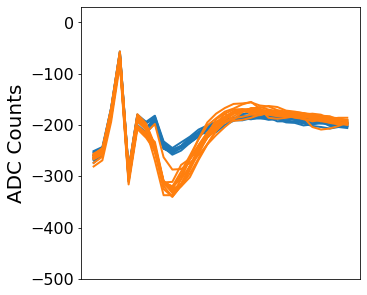

In [92]:
cell = 110
k = 22
p = 16
i = 20
electrode_list =  list(set([e for c in mutual_cells[cell] for e in total_cell_to_electrode_list[c]]))
cell_to_electrode_list = {k:v for k,v in total_cell_to_electrode_list.items() if k in mutual_cells[cell]}

try:
    signal = get_oldlabview_pp_data(estim_analysis_path , p, k)
except:
    print("Signal doesn't exists")


raw_signal = signal[:, electrode_list, start_time_limit:end_time_limit].astype(float) 
raw_signal = remove_row(raw_signal, 20)
num_trials = len(raw_signal)

mask =  get_mask(raw_signal, )
cluster_cliques = cluster_each_cell(raw_signal,mask, cell_to_electrode_list, electrode_list, noise, "", cluster_delay = 0)
event_labels = convert_cliques_to_labels(cluster_cliques, num_trials)
significant_electrodes = np.arange(len(electrode_list))
print("event_labels",event_labels)
event_labels = first_merge_event_cliques_by_noise(electrode_list, raw_signal, event_labels,  mask, significant_electrodes, noise)
event_labels = swap_labels(event_labels, 0, 1)



fig, ax = plt.subplots(1,1, figsize = (5, 5))
#ax.set_title("p %s e %s k %s" %(p, e, k))
j = 1

SMALL_SIZE = 8
MEDIUM_SIZE = 20
BIGGER_SIZE = 12


for i, l in enumerate(list(set(event_labels))):
    
    ax.plot(np.linspace(0, time_limit/20, time_limit), raw_signal[event_labels == l, :].reshape((-1, len(electrode_list)*time_limit))[0, j*time_limit:(j+1)*time_limit].T,linewidth=2, color = "C"+str(i%10), label = f"C^({i})");
    
    ax.plot(np.linspace(0, time_limit/20, time_limit), raw_signal[event_labels == l, :].reshape((-1, len(electrode_list)*time_limit))[:, j*time_limit:(j+1)*time_limit].T,linewidth=2, color = "C"+str(i%10));
    ax.set_ylim([-500,30])
    #ax[i].set_ylabel("adc counts")
    
    # ax.set_xlabel("Time since stimulation (ms)")
    ax.set_ylabel("ADC Counts", fontsize = 20)
    ax.set_xticks([])
#     ax.set_xlabel("Time since stimulation (ms)", fontsize = 20)
#     ax.set_yticklabels()
# ax.legend()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# ax.set_title("signal traces")


event_labels [3 3 3 3 0 0 2 3 0 0 1 3 3 3 2 3 3 4 2 0 3 2 3 3 3]
[0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 4 1 0 0 1 0 0 0]
[1 1 1 1 1 1 4 1 1 1 4 1 1 1 4 1 1 0 4 1 1 4 1 1 1]


(array([-500., -400., -300., -200., -100.,    0.,  100.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

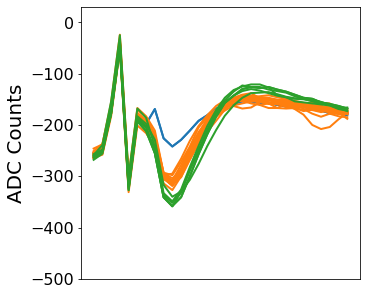

In [91]:
cell = 110
k = 24
p = 16
electrode_list =  list(set([e for c in mutual_cells[cell] for e in total_cell_to_electrode_list[c]]))
cell_to_electrode_list = {k:v for k,v in total_cell_to_electrode_list.items() if k in mutual_cells[cell]}

try:
    signal = get_oldlabview_pp_data(estim_analysis_path , p, k)
except:
    print("Signal doesn't exists")

num_trials = len(signal)
raw_signal = signal[:, electrode_list, start_time_limit:end_time_limit].astype(float) 
mask =  get_mask(raw_signal, )
cluster_cliques = cluster_each_cell(raw_signal,mask, cell_to_electrode_list, electrode_list, noise, "", cluster_delay = 0)
event_labels = convert_cliques_to_labels(cluster_cliques, num_trials)
significant_electrodes = np.arange(len(electrode_list))
print("event_labels",event_labels)
event_labels = first_merge_event_cliques_by_noise(electrode_list, raw_signal, event_labels,  mask, significant_electrodes, noise)
event_labels = merge_specific_groups(event_labels, [0, 3])
event_labels = merge_specific_groups(event_labels, [1, 2])
print(event_labels)
event_labels = swap_labels(event_labels, 4, 0)
event_labels = swap_labels(event_labels, 4, 1)
print(event_labels)

fig, ax = plt.subplots(1,1, figsize = (5, 5))
#ax.set_title("p %s e %s k %s" %(p, e, k))
j = 1

SMALL_SIZE = 8
MEDIUM_SIZE = 20
BIGGER_SIZE = 12


for i, l in enumerate(list(set(event_labels))):
    
    ax.plot(np.linspace(0, time_limit/20, time_limit), raw_signal[event_labels == l, :].reshape((-1, len(electrode_list)*time_limit))[0, j*time_limit:(j+1)*time_limit].T,linewidth=2, color = "C"+str(i%10), label = f"C^({i})");
    
    ax.plot(np.linspace(0, time_limit/20, time_limit), raw_signal[event_labels == l, :].reshape((-1, len(electrode_list)*time_limit))[:, j*time_limit:(j+1)*time_limit].T,linewidth=2, color = "C"+str(i%10));
    ax.set_ylim([-500,30])
    #ax[i].set_ylabel("adc counts")
    
    # ax.set_xlabel("Time since stimulation (ms)")
    ax.set_ylabel("ADC Counts", fontsize = 20)
    ax.set_xticks([])
#     ax.set_xlabel("Time since stimulation (ms)", fontsize = 20)
#     ax.set_yticklabels()
# ax.legend()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# ax.set_title("signal traces")


(array([-500., -400., -300., -200., -100.,    0.,  100.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

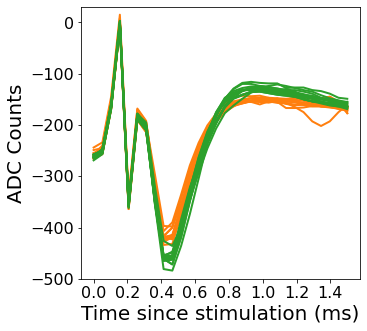

In [90]:
cell = 110
k = 26
p = 16
electrode_list =  list(set([e for c in mutual_cells[cell] for e in total_cell_to_electrode_list[c]]))
cell_to_electrode_list = {k:v for k,v in total_cell_to_electrode_list.items() if k in mutual_cells[cell]}

try:
    signal = get_oldlabview_pp_data(estim_analysis_path , p, k)
except:
    print("Signal doesn't exists")

num_trials = len(signal)
raw_signal = signal[:, electrode_list, start_time_limit:end_time_limit].astype(float) 
mask =  get_mask(raw_signal, )
cluster_cliques = cluster_each_cell(raw_signal,mask, cell_to_electrode_list, electrode_list, noise, "", cluster_delay = 0)
event_labels = convert_cliques_to_labels(cluster_cliques, num_trials)

fig, ax = plt.subplots(1,1, figsize = (5, 5))
#ax.set_title("p %s e %s k %s" %(p, e, k))
j = 1

SMALL_SIZE = 8
MEDIUM_SIZE = 20
BIGGER_SIZE = 12


for i, l in enumerate(list(set(event_labels))):
    
    ax.plot(np.linspace(0, time_limit/20, time_limit), raw_signal[event_labels == l, :].reshape((-1, len(electrode_list)*time_limit))[0, j*time_limit:(j+1)*time_limit].T,linewidth=2, color = "C"+str(i%10+1), label = f"C^({i})");
    
    ax.plot(np.linspace(0, time_limit/20, time_limit), raw_signal[event_labels == l, :].reshape((-1, len(electrode_list)*time_limit))[:, j*time_limit:(j+1)*time_limit].T,linewidth=2, color = "C"+str(i%10+1));
    ax.set_ylim([-500,30])
    #ax[i].set_ylabel("adc counts")
    
    # ax.set_xlabel("Time since stimulation (ms)")
    ax.set_ylabel("ADC Counts", fontsize = 20)
    ax.set_xlabel("Time since stimulation (ms)", fontsize = 20)
#     ax.set_yticklabels()
# ax.legend()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# ax.set_title("signal traces")
